In [1]:
using Random, Plots, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures, Revise

In [2]:
Revise.track("./SSA-basic.jl")
include("./SSA-basic.jl")
using .SSAnonVD

In [53]:
df_nuc = DataFrame(CSV.File("./data/nuclear-vol-corr.csv"));
df_cyto = DataFrame(CSV.File("./data/cyto-vol-corr.csv"));
delete!(df_nuc, 2)
delete!(df_cyto, 2)

,Group,N,Mean,Variance,FF,gene
,Int64,Int64,Float64,Float64,Float64,String31
1,1,1142,4.40026,2.73219,0.620915,bub1WTymEGFP
2,3,2155,2.85252,1.87396,0.656948,mad1WTymEGFP
3,4,1382,1.74182,1.07961,0.619818,mad1endog
4,5,3064,2.89691,2.38782,0.824265,mad2WTymEGFP
5,6,2661,3.52603,2.55645,0.725023,mad3WTymEGFP
6,7,1425,17.8811,11.5739,0.64727,rpb1endog
7,8,589,5.42553,4.77273,0.879679,sep1WTymEGFP-hph


In [54]:
df_cyto

,Group,N,Mean,Variance,FF,gene
,Int64,Int64,Float64,Float64,Float64,String31
1,1,1142,4.40026,2.73219,0.620915,bub1WTymEGFP
2,3,2155,2.85252,1.87396,0.656948,mad1WTymEGFP
3,4,1382,1.74182,1.07961,0.619818,mad1endog
4,5,3064,2.89691,2.38782,0.824265,mad2WTymEGFP
5,6,2661,3.52603,2.55645,0.725023,mad3WTymEGFP
6,7,1425,17.8811,11.5739,0.64727,rpb1endog
7,8,589,5.42553,4.77273,0.879679,sep1WTymEGFP-hph


In [55]:
gnames = df_cyto[!,"gene"]
Ns = df_nuc[!,"N"];
cyto_means = df_cyto[!,"Mean"];
nuc_FFs = df_nuc[!,"FF"];
cyto_FFs = df_cyto[!,"FF"];

Set the hyperparameters to $S=R=3$.

In [56]:
hypars = [3,3];

In [9]:
tdeg = 1;
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [1]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

In [46]:
function new_distance(traj1::Matrix, traj2::Matrix)
    return sum([((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end
function new_distance(traj1::Vector, traj2::Vector)
    return sum([((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end

new_distance (generic function with 2 methods)

In [38]:
using GpABC

## For the first gene.

In [39]:
gnames[1]

"bub1WTymEGFP"

In [40]:
function simulator_fn_1(pars)
    op = SSA(Ns[1], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_1 (generic function with 1 method)

In [41]:
thres_cutoff_1 = sum([new_distance(simulator_fn_1([1,100,1]),simulator_fn_1([1,100,1])) for i in 1:100])/100

0.006814550787983412

In [42]:
pal = cgrad(:tol_muted);
cpal = [pal[i] for i in 1/5:1/5:1.0]
population_colors = cpal

In [105]:
# ABC priors
pf = (hypars[1]-1)/2
priors_1 = [Uniform(pf*0.5,pf*20.5), Uniform(0.5, 75.5), Uniform(20.,220)]

# ABC hpars
n_particles = 1000;
threshold_schedule_1 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_1]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.006814550787983412

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.006814550787983412


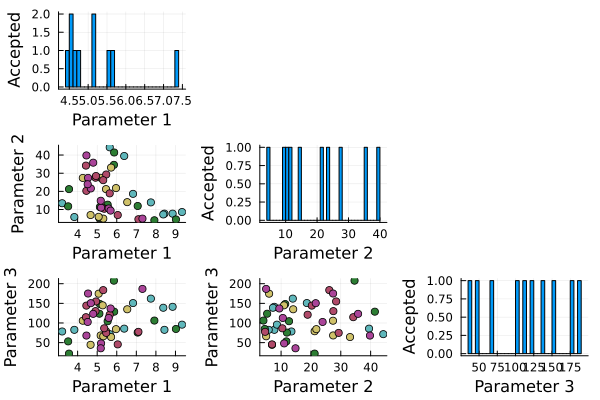

In [47]:
sim_abcsmc_res_1 = SimulatedABCSMC(reshape([cyto_means[1],nuc_FFs[1],cyto_FFs[1]],(3,1)),
    simulator_fn_1,
    priors_1,
    threshold_schedule_1,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_1, population_colors=population_colors)

In [75]:
fieldnames(typeof(sim_abcsmc_res_1))

(:n_params, :n_accepted, :n_tries, :threshold_schedule, :population, :distances, :weights)

In [79]:
sim_abcsmc_res_1.population[end]

10×3 Matrix{Float64}:
 4.7962   35.7965   123.293
 5.19846  11.0382    47.9739
 4.45056  39.7792    67.9572
 4.6737   21.6016   150.402
 7.31314   4.98802  186.765
 5.58869  10.5813   112.737
 4.53445  27.4249   175.013
 5.6849    9.41479  136.941
 4.51386  23.9089   102.622
 5.18235  14.8323    35.5666

In [80]:
using JLD

In [90]:
save("./ABC-basic/ABC-$(gnames[1]).jld", "ABC", sim_abcsmc_res_1)

In [89]:
load("./ABC-basic/ABC-$(gnames[1]).jld")["ABC"];

## For the second gene.

In [96]:
gnames[2]

"mad1WTymEGFP"

In [59]:
function simulator_fn_2(pars)
    op = SSA(Ns[2], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_2 (generic function with 1 method)

In [60]:
thres_cutoff_2 = sum([new_distance(simulator_fn_2([1,100,1]),simulator_fn_2([1,100,1])) for i in 1:100])/100

0.004399672845931419

In [97]:
# ABC priors
priors_2 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 40.5), Uniform(20.,220)]

# ABC hpars
threshold_schedule_2 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_2]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.004399672845931419

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.004399672845931419


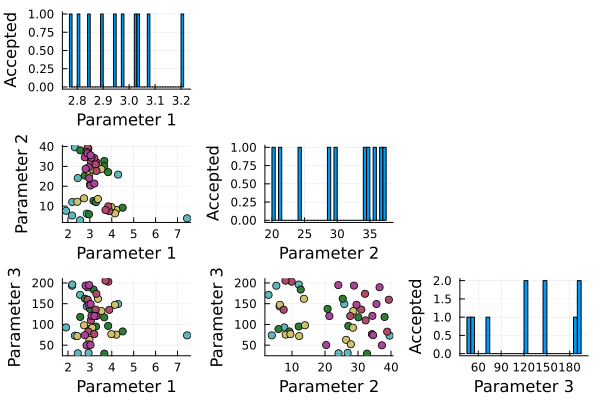

In [98]:
sim_abcsmc_res_2 = SimulatedABCSMC(reshape([cyto_means[2],nuc_FFs[2],cyto_FFs[2]],(3,1)),
    simulator_fn_2,
    priors_2,
    threshold_schedule_2,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_2, population_colors=population_colors)

In [99]:
save("./ABC-basic/ABC-$(gnames[2]).jld", "ABC", sim_abcsmc_res_2)

## For the third gene.

In [100]:
gnames[3]

"mad1endog"

In [103]:
function simulator_fn_3(pars)
    op = SSA(Ns[3], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_3 (generic function with 1 method)

In [104]:
thres_cutoff_3 = sum([new_distance(simulator_fn_3([1,100,1]),simulator_fn_3([1,100,1])) for i in 1:100])/100

0.006133031214167122

In [94]:
# ABC priors
priors_3 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 10.5), Uniform(0.5,100.5)]

# ABC hpars
threshold_schedule_3 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_3]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.0060094383566563206

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.0060094383566563206


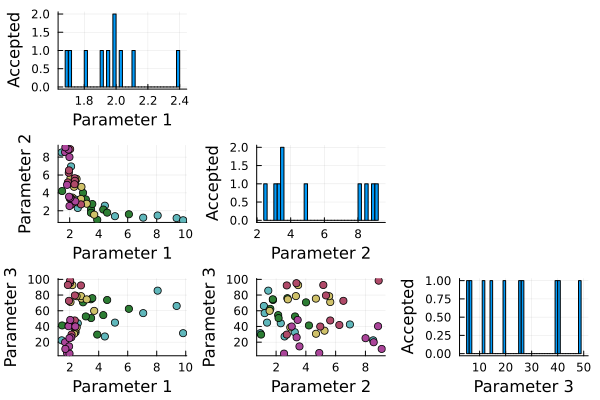

In [95]:
sim_abcsmc_res_3 = SimulatedABCSMC(reshape([cyto_means[3],nuc_FFs[3],cyto_FFs[3]],(3,1)),
    simulator_fn_3,
    priors_3,
    threshold_schedule_3,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_3, population_colors=population_colors)

In [ ]:
save("./ABC-basic/ABC-$(gnames[3]).jld", "ABC", sim_abcsmc_res_3)

## For the fourth gene.

In [135]:
gnames[4]

"mad2WTymEGFP"

In [136]:
function simulator_fn_4(pars)
    op = SSA(Ns[4], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_4 (generic function with 1 method)

In [137]:
thres_cutoff_4 = 3*sum([new_distance(simulator_fn_4([1,100,1]),simulator_fn_4([1,100,1])) for i in 1:100])/100

0.006735684320075211

In [138]:
# ABC priors
priors_4 = [Uniform(pf*0.5,pf*35.5), Uniform(0.5, 10.5), Uniform(0.5,20.5)]

# ABC hpars
threshold_schedule_4 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_4]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.006735684320075211

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.006735684320075211


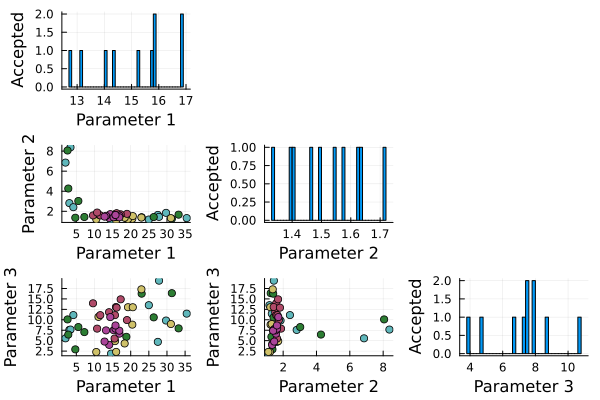

In [139]:
sim_abcsmc_res_4 = SimulatedABCSMC(reshape([cyto_means[4],nuc_FFs[4],cyto_FFs[4]],(3,1)),
    simulator_fn_4,
    priors_4,
    threshold_schedule_4,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_4, population_colors=population_colors)

In [140]:
save("./ABC-basic/ABC-$(gnames[4]).jld", "ABC", sim_abcsmc_res_4)

## For the fifth gene.

In [141]:
gnames[5]

"mad3WTymEGFP"

In [142]:
function simulator_fn_5(pars)
    op = SSA(Ns[5], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_5 (generic function with 1 method)

In [143]:
thres_cutoff_5 = sum([new_distance(simulator_fn_5([1,100,1]),simulator_fn_5([1,100,1])) for i in 1:100])/100

0.00296838726615623

In [144]:
# ABC priors
priors_5 = [Uniform(pf*0.5,pf*20.5), Uniform(0.5, 10.5), Uniform(20,220)]

# ABC hpars
threshold_schedule_5 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_5]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.00296838726615623

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.00296838726615623


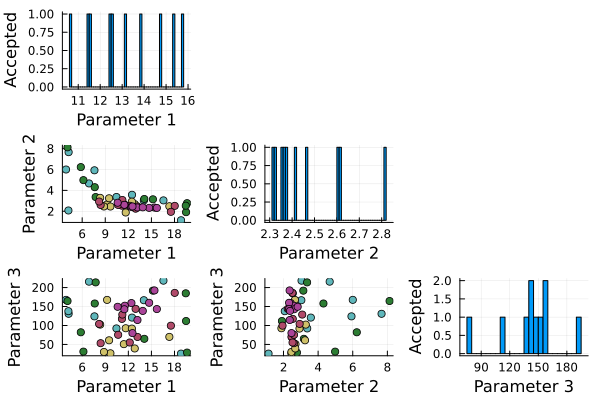

In [145]:
sim_abcsmc_res_5 = SimulatedABCSMC(reshape([cyto_means[5],nuc_FFs[5],cyto_FFs[5]],(3,1)),
    simulator_fn_5,
    priors_5,
    threshold_schedule_5,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_5, population_colors=population_colors)

In [146]:
save("./ABC-basic/ABC-$(gnames[5]).jld", "ABC", sim_abcsmc_res_5)

## For the sixth gene.

In [147]:
gnames[6]

"rpb1endog"

In [148]:
function simulator_fn_6(pars)
    op = SSA(Ns[6], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_6 (generic function with 1 method)

In [149]:
thres_cutoff_6 = sum([new_distance(simulator_fn_6([1,100,1]),simulator_fn_6([1,100,1])) for i in 1:100])/100

0.005564514700029682

In [150]:
# ABC priors
priors_6 = [Uniform(pf*25,pf*75), Uniform(0.5, 30.5), Uniform(0.5, 50.5)]

# ABC hpars
threshold_schedule_6 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_4]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.006735684320075211

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.006735684320075211


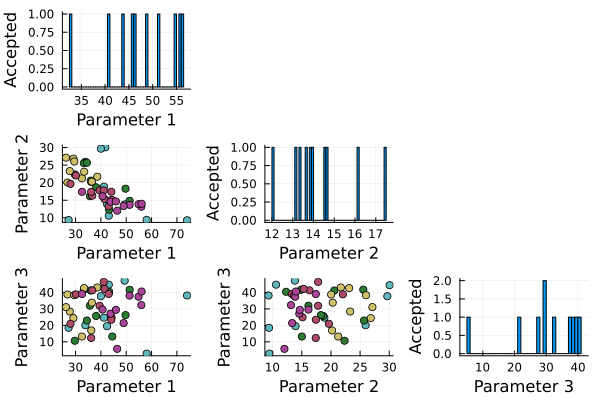

In [151]:
sim_abcsmc_res_6 = SimulatedABCSMC(reshape([cyto_means[6],nuc_FFs[6],cyto_FFs[6]],(3,1)),
    simulator_fn_6,
    priors_6,
    threshold_schedule_6,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_6, population_colors=population_colors)

In [152]:
save("./ABC-basic/ABC-$(gnames[6]).jld", "ABC", sim_abcsmc_res_6)

## For the fourth gene.

In [153]:
gnames[7]

"sep1WTymEGFP-hph"

In [154]:
function simulator_fn_7(pars)
    op = SSA(Ns[7], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_7 (generic function with 1 method)

In [155]:
thres_cutoff_7 = sum([new_distance(simulator_fn_7([1,100,1]),simulator_fn_7([1,100,1])) for i in 1:100])/100

0.013101467695418994

In [156]:
# ABC priors
priors_7 = [Uniform(pf*0.5,pf*100.5), Uniform(0.5, 5.5), Uniform(0.1,30.1)]

# ABC hpars
threshold_schedule_7 = [0.2, 0.1, 0.05, 0.025, thres_cutoff_4]

5-element Vector{Float64}:
 0.2
 0.1
 0.05
 0.025
 0.006735684320075211

[ Info: GpABC rejection simulation. ϵ = 0.2.
[ Info: GpABC SMC simulation ϵ = 0.1
[ Info: GpABC SMC simulation ϵ = 0.05
[ Info: GpABC SMC simulation ϵ = 0.025
[ Info: GpABC SMC simulation ϵ = 0.006735684320075211


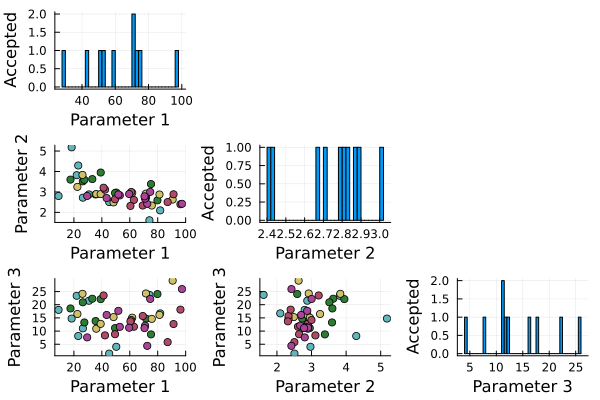

In [157]:
sim_abcsmc_res_7 = SimulatedABCSMC(reshape([cyto_means[7],nuc_FFs[7],cyto_FFs[7]],(3,1)),
    simulator_fn_7,
    priors_7,
    threshold_schedule_7,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true)
plot(sim_abcsmc_res_7, population_colors=population_colors)

In [158]:
save("./ABC-basic/ABC-$(gnames[7]).jld", "ABC", sim_abcsmc_res_7)